In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

import utils

In [2]:
#Unet CLASICA (nuevo formato)

class DownConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(DownConv, self).__init__()
        self.DownLayer = nn.Sequential(

            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        
    def forward(self, x ):
        x = self.DownLayer(x)
        return x
    
        
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.Pool = torch.nn.MaxPool2d(kernel_size = 2)
        
    def forward (self,x):
        x = self.Pool(x)
        return x
    
        
class UpConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(UpConv, self).__init__()
        
        self.ConvTransp = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #self.ConvTransp = torch.nn.ConvTranspose2d((in_channels//2), out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.UpConv = DownConv(in_channels, out_channels)
        
    def forward(self, xAnt , xDown):
            
        layerConvTransposed = self.ConvTransp(xAnt)
        concat = torch.cat([layerConvTransposed,xDown], dim=1)
        x = self.UpConv(concat)
            
        return x

class OutUnet(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(OutUnet, self).__init__()
        self.OutUnet = torch.nn.Conv2d(in_channels,out_channels, kernel_size = 1)
        
    def forward(self,x):
        x = self.OutUnet(x)
        return x

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.Layer1Down = DownConv(1,32)
        self.Layer2Down = DownConv(32,64)
        self.Layer3Down = DownConv(64,128)
        self.Layer4Down = DownConv(128,256)
        self.Layer5Down = DownConv(256,512)
        
        self.Middle = DownConv(512,512)
        
        self.Layer1Up = UpConv(1024,256)
        self.Layer2Up = UpConv(512,128)
        self.Layer3Up = UpConv(256,64)
        self.Layer4Up = UpConv(128,64)
        self.Layer5Up = UpConv(64+32,32)
        
        self.MaxPool = MaxPool()
        
        self.Out = OutUnet(32,1)
        
        
    
    def forward(self, x):

        # Down
        conv1 = self.Layer1Down(x)
        maxPool1 = self.MaxPool(conv1)
        
        conv2 = self.Layer2Down(maxPool1)
        maxPool2 = self.MaxPool(conv2)
        
        conv3 = self.Layer3Down(maxPool2)
        maxPool3 = self.MaxPool(conv3)
        
        conv4 = self.Layer4Down(maxPool3)
        maxPool4 = self.MaxPool(conv4)
        
        conv5 = self.Layer5Down(maxPool4)
        maxPool5 = self.MaxPool(conv5)
        
        middle = self.Middle(maxPool5)
        
        # Up
        up1= self.Layer1Up(middle,conv5)
        up2= self.Layer2Up(up1,conv4)
        up3= self.Layer3Up(up2,conv3)
        up4= self.Layer4Up(up3,conv2)
        up5= self.Layer5Up(up4,conv1)
        
        outUNet = self.Out(up5)
        
        return outUNet

unet = Unet()

In [3]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [4]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]


img_noisyDataSet1 = (np.expand_dims(img_noisyDataSet1, axis=-3)).astype(np.float32)
img_noisyDataSet2 = (np.expand_dims(img_noisyDataSet2, axis=-3)).astype(np.float32)
img_groundTruth = (np.expand_dims(img_groundTruth, axis=-3)).astype(np.float32)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [5]:
# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,valid_noisyImage,train_groundTruth,valid_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.3)

# Create dictionaries with training sets:
trainingSet = dict([('input',train_noisyImage), ('output', train_groundTruth)])
validSet = dict([('input',valid_noisyImage), ('output', valid_groundTruth)])

print('Data set size. Training set: {0}. Valid set: {1}.'.format(trainingSet['input'].shape[0], validSet['input'].shape[0]))

# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

Data set size. Training set: 1208. Valid set: 518.


In [6]:
# Test set

inputsTestSet = torch.from_numpy(trainingSet['input'][:,:,:,:])
inputsTestSet = torchvision.transforms.functional.rotate(inputsTestSet,15)

In [7]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Codigo entrenamiento Martin

# defino batches

best_vloss = 1000000000

batchSizeTrain = 4
batchSizeValid = 4
numBatchesTrain = np.round(trainingSet['input'].shape[0] / batchSizeTrain).astype(int)
numBatchesValid = np.round(validSet['input'].shape[0] / batchSizeValid).astype(int)

# Show dev set loss every showDevLossStep batches:
showDevLossStep = 4

printStep = 1
# figImages, axs = plt.subplots(3, 1,figsize=(20,20))
# figLoss, axLoss = plt.subplots(1, 1,figsize=(5,5))

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train
loss_values = []
lossValuesTrainingSet = []
iterationNumbers = []
lossValuesDevSet = []
iterationNumbersForDevSet = []
lossValuesTrainingSetEpoch = []

lossValuesEpoch = []

iter = 0

EPOCHS = 20

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
    lossValuesTrainingSetEpoch = []

    running_loss = 0.0

    unet.train(True)
    for i in range(numBatchesTrain):
        # get the inputs

        inputs = torch.from_numpy(trainingSet['input'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])
        gt = torch.from_numpy(trainingSet['output'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # Save loss values:
        lossValuesTrainingSet.append(loss.item())
        lossValuesTrainingSetEpoch.append(loss.item())
        iterationNumbers.append(iter)

        if i % printStep == (printStep - 1):  # print every printStep mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

            # Show input images:
            # plt.figure(figImages)
            # plt.axes(axs[0])
            # imshow(torchvision.utils.make_grid(inputs, normalize=True))
            # axs[0].set_title('Input Batch {0}'.format(i))
            # plt.axes(axs[1])
            # imshow(torchvision.utils.make_grid(outputs, normalize=True))
            # axs[1].set_title('Output Epoch {0}'.format(epoch))
            # plt.axes(axs[2])
            # imshow(torchvision.utils.make_grid(gt, normalize=True))
            # axs[2].set_title('Ground Truth')
            # Show loss:
            # plt.figure(figLoss)
            # axLoss.plot(iterationNumbers, lossValuesTrainingSet)
            # axLoss.plot(iterationNumbersForDevSet, lossValuesDevSet)
            # plt.draw()
            # plt.pause(0.0001)

            # Update iteration number:
        iter = iter + 1

    lossValuesEpoch.append(np.mean(lossValuesTrainingSetEpoch))
    unet.train(False)
    running_vloss = 0.0


    for i in range(numBatchesValid):
        print(i)

        vinputs = torch.from_numpy(validSet['input'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])
        vgt = torch.from_numpy(validSet['output'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])

        voutputs = unet(vinputs)
        vloss = criterion(voutputs, vgt)
        vloss.backward()
        running_vloss += vloss

        lossValuesDevSet.append(vloss.item())


    avg_vloss = np.mean(lossValuesDevSet)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch)
        torch.save(unet.state_dict(), model_path)

    print('LOSS train {} valid {}'.format(lossValuesTrainingSet[-1], avg_vloss))

print('Finished Training')

[1,     1] loss: 0.262
[1,     2] loss: 0.713
[1,     3] loss: 0.627
[1,     4] loss: 0.668
[1,     5] loss: 0.614
[1,     6] loss: 0.650
[1,     7] loss: 0.626
[1,     8] loss: 0.176
[1,     9] loss: 0.368
[1,    10] loss: 0.268
[1,    11] loss: 0.366
[1,    12] loss: 0.243
[1,    13] loss: 0.397
[1,    14] loss: 0.318
[1,    15] loss: 0.215
[1,    16] loss: 0.407
[1,    17] loss: 0.176
[1,    18] loss: 0.315
[1,    19] loss: 0.185
[1,    20] loss: 0.530
[1,    21] loss: 0.115
[1,    22] loss: 0.214
[1,    23] loss: 0.328
[1,    24] loss: 0.347
[1,    25] loss: 0.166
[1,    26] loss: 0.124
[1,    27] loss: 0.314
[1,    28] loss: 0.208
[1,    29] loss: 0.160
[1,    30] loss: 0.215
[1,    31] loss: 0.096
[1,    32] loss: 0.152
[1,    33] loss: 0.343
[1,    34] loss: 0.176
[1,    35] loss: 0.268
[1,    36] loss: 0.169
[1,    37] loss: 0.105
[1,    38] loss: 0.123
[1,    39] loss: 0.125
[1,    40] loss: 0.343
[1,    41] loss: 0.224
[1,    42] loss: 0.097
[1,    43] loss: 0.101
[1,    44] 

NameError: name 'numpy' is not defined

In [14]:
np.mean(lossValuesTrainingSet)

0.1457749114106625

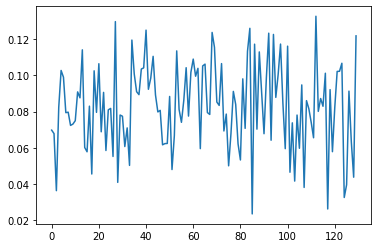

In [12]:
plt.plot(lossValuesDevSet)

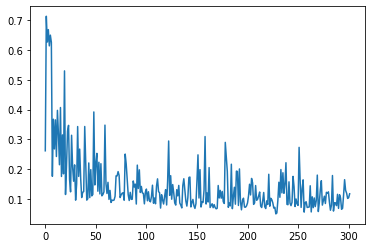

In [15]:
plt.plot(lossValuesTrainingSet)